# Train student GAN

In [1]:
from sklearn.preprocessing import StandardScaler
from itertools import repeat
from tqdm import tqdm_notebook, tqdm
from torch.autograd import Variable, grad
from torch.optim import AdamW, RMSprop
from torch import autograd
from torch import nn

import wandb
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
SIGNAL = 'Pion'
MAX_EPOCH = 4000
TEACHER_LAYERS = 10
STUDENT_LAYERS = 3
LATENT_DIMENSIONS = 256
BATCH_SIZE = 5000
BATCH_SIZE_TEST = 8192
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
weight_cliping_limit = 0.015
lr = 0.00005

## Data

In [5]:
train = pd.read_csv('../data/MCRICHdata/MCRICH_train.csv')
test = pd.read_csv('../data/MCRICHdata/MCRICH_test.csv')

In [6]:
# Download data
train = pd.read_csv('../data/MCRICHdata/MCRICH_train.csv')
test = pd.read_csv('../data/MCRICHdata/MCRICH_test.csv')
# Filter it by the signal
train = train[train['Signal'] == SIGNAL]
test = test[test['Signal'] == SIGNAL]
# Delete useless columns
del train['Signal']
del test['Signal']

In [7]:
print(len(train))
train.head()

1000006


,TrackP,TrackPt,NumProtoParticles,RichDLLe,RichDLLmu,RichDLLk,RichDLLp,RichDLLbt
2286,5383.890137,292.449890,145.0,-8.547900,1.1894,-4.8921,-4.8921,-4.8921
2287,5875.910156,537.121704,32.0,-30.771500,-9.2196,-24.2808,-24.2808,-24.2808
2288,5114.390137,996.601135,92.0,-53.311001,-27.5772,-30.7045,-30.7045,-30.7045
2289,20254.830078,514.304382,131.0,-6.002100,-2.0739,-1.2550,-1.6131,-1.6131
2290,3026.860107,303.679565,68.0,-17.817699,0.4731,-0.4927,-0.4927,-0.4927


In [8]:
# drop errors 
for col in ['RichDLLe', 'RichDLLmu', 'RichDLLk', 'RichDLLp', 'RichDLLbt']:
    train = train[train[col] != -999]
    test = test[test[col] != -999]
len(train)

974413

In [9]:
scalers = [None for i in range(len(train.columns))]
for idx, i in enumerate(train.columns):
    values = train[i].values
    values = values.reshape((len(values), 1))
    scaler = StandardScaler()
    scaler = scaler.fit(values)
    scalers[idx] = scaler
    train[i] = scaler.transform(values)
    values_test = test[i].values
    values_test = values_test.reshape((len(values_test), 1))
    test[i] = scaler.transform(values_test)

In [10]:
train_x, train_y = train[train.columns[:3]], train[train.columns[3:]]
test_x, test_y = test[test.columns[:3]], test[test.columns[3:]]

In [11]:
class ParticleSet(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data_x, self.data_y = data[data.columns[:3]].values, data[data.columns[3:]].values
    
    def __len__(self):
        return self.data_x.shape[0]
    
    def __getitem__(self, index):
        return (self.data_x[index], self.data_y[index])

    
train_loader = torch.utils.data.DataLoader(ParticleSet(train),
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           pin_memory=True)

test_loader = torch.utils.data.DataLoader(ParticleSet(test),
                                          batch_size=BATCH_SIZE_TEST,
                                          shuffle=False,
                                          pin_memory=True)

## Model

In [12]:
class Generator(nn.Module):
    def __init__(self, noise_size=64, hidden_size=128, depth=5):
        super(Generator, self).__init__()
        self.noise_size = noise_size
        self.layers = nn.Sequential(*(
            [nn.Linear(noise_size + 3, hidden_size), nn.SELU()]
            + [nn.Linear(hidden_size, hidden_size), nn.SELU()] * (depth - 1)
            + [nn.Linear(hidden_size, 5)]
        ))

    def forward(self, x, noise=None):
        if noise is None:
            noise = get_noise(x.shape[0], self.noise_size)
        return self.layers(torch.cat([x, noise], dim=1))

    
class Discriminator(nn.Module):
    def __init__(self, hidden_size=128, depth=5):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(*(
            [nn.Linear(train.shape[1], hidden_size), nn.SELU()]
            + [nn.Linear(hidden_size, hidden_size), nn.SELU()] * (depth - 1)
            + [nn.Linear(hidden_size, 512)]
        ))

    def forward(self, x):
        return self.layers(x)
    
    def get_after_n(self, x, n):
        for idx, (name, layer) in enumerate(self._modules.items()):
            x = layer(x)
            if idx == n:
                break
        return x
    
    
def get_noise(batch_size, noise_size=128, mean=0, std=1):
    return torch.zeros(batch_size, noise_size).normal_(mean, std).to(device)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [13]:
G = Generator(depth=TEACHER_LAYERS, hidden_size=LATENT_DIMENSIONS).to(device)
G.apply(init_weights)

D = Discriminator(depth=TEACHER_LAYERS, hidden_size=LATENT_DIMENSIONS).to(device)
D.apply(init_weights)

G_student = Generator(depth=STUDENT_LAYERS, hidden_size=LATENT_DIMENSIONS).to(device)
G_student.apply(init_weights)

D_student = Discriminator(depth=STUDENT_LAYERS, hidden_size=LATENT_DIMENSIONS).to(device)
D_student.apply(init_weights);

In [14]:
optimizerD = RMSprop(D_student.parameters(), lr=lr) 
optimizerG = RMSprop(G_student.parameters(), lr=lr) 

D.load_state_dict(torch.load(f'{SIGNAL}/D_teacher_2000.pth'))
G.load_state_dict(torch.load(f'{SIGNAL}/G_teacher_2000.pth'))

D.to(device)
G.to(device)
D_student.to(device)
G_student.to(device);

## Train

In [15]:
# Weights & Biases
wandb.init(project="rich-gan-distilling")

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: apshirokov (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.13 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [16]:
# The coefficients needed for losses
alpha = 10
l_4coef = 0.1
l_5coef = 0.0000001
l_7coef = 0.00001
l_8coef = 0.0001

In [17]:
def l1_norm(x):
    return torch.abs(x).sum(dim=(1))

In [ ]:
G_student = G_student.float()
D_student = D_student.float()
G = G.float()
D = D.float()
step = 0
for epoch in tqdm(range(MAX_EPOCH)):
    for ii, batch in enumerate(train_loader, 0):
        x = batch[0].float().to(device)
        dll = batch[1].float().to(device)
        real_row = torch.cat([x, dll], dim=1)
        
        if (ii + 1) % 5:
            # Train Discriminator...
            D_student.zero_grad()
            
            # Clamp parameters to a range [-c, c], c=self.weight_cliping_limit
            for p in D.parameters():
                p.data.clamp_(-weight_cliping_limit, weight_cliping_limit)
            
            # with real dll
            real_loss = D_student(real_row)
            # with fake dll
            fake_dll = G_student(x).detach()
            fake_row = torch.cat([x, fake_dll], dim=1)
            fake_loss = D_student(fake_row)
            # GP
            #gradient_penalty = calc_derv4gp(D_student, real_row, fake_row)
            # total discriminator loss
            discriminator_loss = fake_loss.mean() - real_loss.mean()# + gradient_penalty*10
            wandb.log({"Critic loss": discriminator_loss.item()})
            discriminator_loss.backward()
            
            teacher_dll = G(x).detach()
            teacher_row = torch.cat([x, teacher_dll], dim=1)
            # Calculate L_Gt  (Fcn. 7 from paper) 
            output_gt = -l_7coef*D_student(teacher_row).mean()
            wandb.log({"L_Gt": output_gt.item()})
            output_gt.backward()
            
            # Calculate L_tri (Fcn. 8 from paper)
            output_tri = l1_norm(D_student.get_after_n(real_row, 3) - D_student.get_after_n(teacher_row, 3)) - \
                      l1_norm(D_student.get_after_n(real_row, 3) - D_student.get_after_n(fake_row, 3)) + alpha
            output_tri = l_8coef*torch.clamp(output_tri, min=0).mean()
            output_tri.backward()
            wandb.log({"L_tri": output_tri.item()})
            
            optimizerD.step()
        else:
            # Train Generator
            optimizerG.zero_grad()
            fake_dll = G_student(x)
            fake_row = torch.cat([x, fake_dll], dim=1)
            teacher_dll = G(x)
            teacher_row = torch.cat([x, teacher_dll], dim=1)
            generator_loss = -D_student(fake_row).mean()
            wandb.log({"Generator loss": generator_loss.item()})
            generator_loss.backward()
            
            # Calculate L1_loss (Fcn. 4 from paper)
            l1 = l_4coef * (l1_norm(G(x) - G_student(x)).pow(2))
            # Calculate L_perc  (Fcn. 5 from paper)
            fake_dll = G_student(x)
            fake_row = torch.cat([x, fake_dll], dim=1)
            teacher_dll = G(x)
            teacher_row = torch.cat([x, teacher_dll], dim=1)
            l_perc = l_5coef * (l1_norm(D.get_after_n(teacher_row, 3) - D.get_after_n(fake_row, 3)).pow(2))
            
            # Combine two losses
            l_kd_generator = (l1 + l_perc).mean()
            l_kd_generator.backward()
            # L1 ONLY
#             l1.backward()
            
            wandb.log({"L1_loss": l1.mean().item()})
            wandb.log({"L_perc": l_perc.mean().item()})
            wandb.log({"L1_loss + L_perc": l_kd_generator.item()})
            
            optimizerG.step()
        step += 1
    # Save weights
    if epoch % 100 == 0:
        torch.save(D_student.state_dict(),f'{SIGNAL}/D_student_full.pth')
        torch.save(G_student.state_dict(),f'{SIGNAL}/G_student_full.pth')

 29%|██▉       | 1166/4000 [9:15:59<22:33:40, 28.66s/it]

## Test

In [15]:
def inversescale(data):
    for i in range(data.shape[1]):
        scaler = scalers[i+3]
        column = data[:, i]
        column = column.reshape((len(column), 1))
        data[:,i] = scaler.inverse_transform(column)[:,0]
    return data

In [16]:
G_student.load_state_dict(torch.load(f'{SIGNAL}/G_student_full.pth'))
D_student.load_state_dict(torch.load(f'{SIGNAL}/D_student_full.pth'))

<All keys matched successfully>

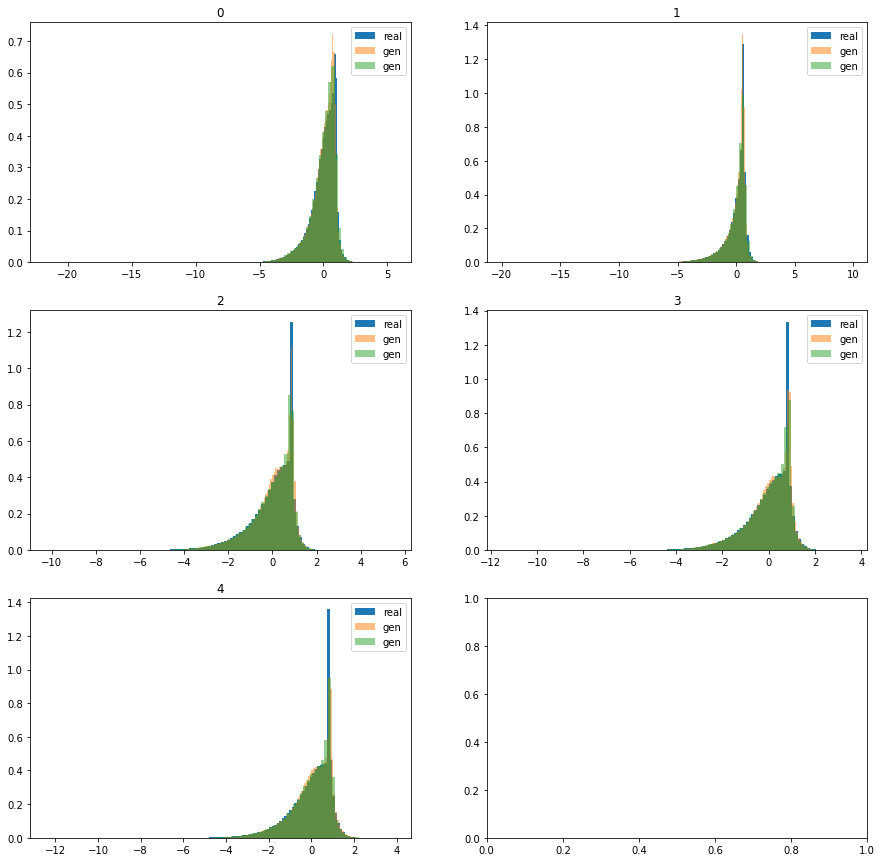

In [21]:
dlls = None
teacher_generated = None
student_generated = None

with torch.no_grad():
    for x, dll in test_loader:
        dll = dll.detach().cpu().numpy()
        x = x.float().to(device)
        gen_tea = G(x).detach().cpu().numpy()
        gen_stu = G_student(x).detach().cpu().numpy()

        if dlls is None:
            dlls = dll
        else:
            dlls = np.concatenate((dlls, dll))

        if teacher_generated is None:
            teacher_generated = gen_tea
        else:
            teacher_generated = np.concatenate((teacher_generated, gen_tea))
            
        if student_generated is None:
            student_generated = gen_tea
        else:
            student_generated = np.concatenate((student_generated, gen_stu))

    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    for particle_type, ax in zip((0, 1, 2, 3, 4), axes.flatten()):
        sns.distplot(dlls[:, particle_type], hist_kws={'alpha': 1}, kde=False, bins=100, ax=ax, label="real", norm_hist=True)
        sns.distplot(teacher_generated[:, particle_type], hist_kws={'alpha': 0.5}, kde=False, bins=100, ax=ax, label="gen", norm_hist=True)
        sns.distplot(student_generated[:, particle_type], hist_kws={'alpha': 0.5}, kde=False, bins=100, ax=ax, label="gen", norm_hist=True)
        ax.legend()
        ax.set_title(particle_type)

    plt.show()

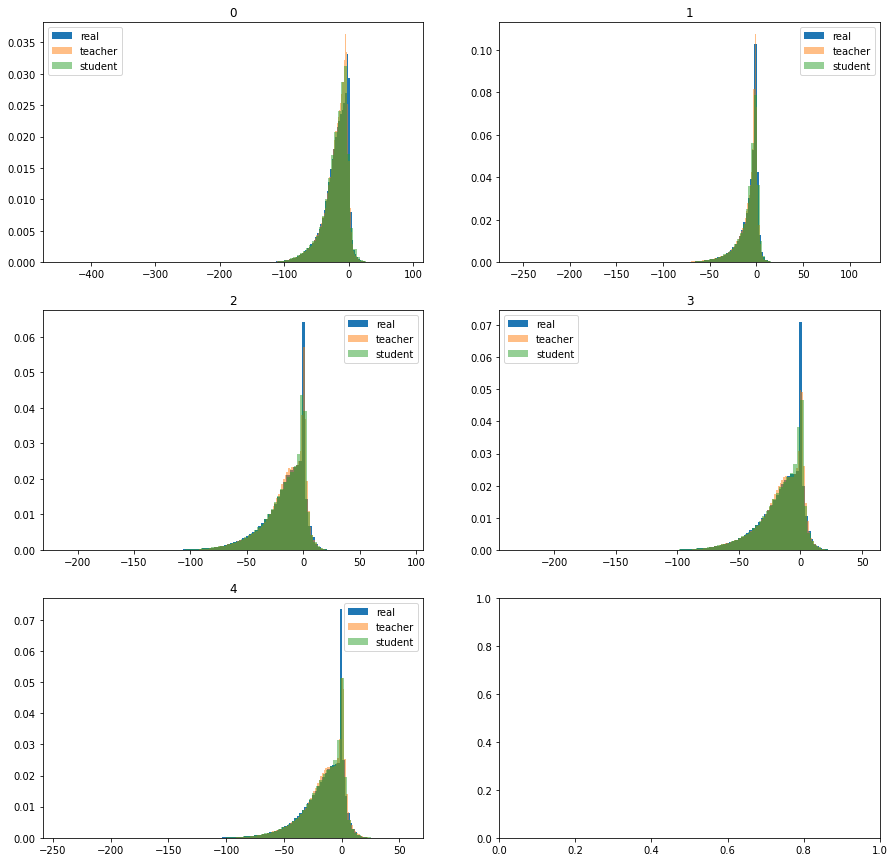

In [22]:
dlls_inversed = inversescale(dlls)
teacher_generated_inversed = inversescale(teacher_generated)
student_generated_inversed = inversescale(student_generated)


fig, axes = plt.subplots(3, 2, figsize=(15, 15))
for particle_type, ax in zip((0, 1, 2, 3, 4), axes.flatten()):
    sns.distplot(dlls_inversed[:, particle_type], hist_kws={'alpha': 1}, kde=False, bins=100, ax=ax, label="real", norm_hist=True)
    sns.distplot(teacher_generated_inversed[:, particle_type], hist_kws={'alpha': 0.5}, kde=False, bins=100, ax=ax, label="teacher", norm_hist=True)
    sns.distplot(student_generated_inversed[:, particle_type], hist_kws={'alpha': 0.5}, kde=False, bins=100, ax=ax, label="student", norm_hist=True)
    ax.legend()
    ax.set_title(particle_type)

plt.show()

In [24]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

y = [1] * dlls_inversed.shape[0]
y.extend(list([0] * student_generated_inversed.shape[0]))
X = np.concatenate((dlls_inversed, student_generated_inversed))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

classifier = CatBoostClassifier(iterations=1000,
                custom_metric=['Logloss', 'AUC'],
                task_type="GPU",
                devices='0:1')

classifier.fit(X_train,
                y_train,
                verbose=False,
                plot=False);

predicted = classifier.predict(X_test)

from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
metrics.auc(fpr, tpr)

0.717739156886109